<a href="https://colab.research.google.com/github/ogigo/object_detection_with_yolo/blob/main/tomatto_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
api_token = {"username":"shahedshoyab","key":"1aa2d9748604f09744dac84eb27b107f"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:json.dump(api_token, file)

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download andrewmvd/tomato-detection

 94% 169M/180M [00:02<00:00, 84.3MB/s]
100% 180M/180M [00:02<00:00, 85.6MB/s]


In [ ]:
!unzip tomato-detection.zip 

In [35]:
import pandas as pd
import glob
import xml.etree.ElementTree as ET 
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

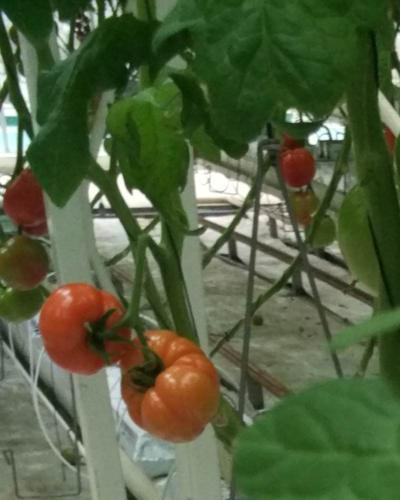

In [8]:
image=Image.open("/content/images/tomato0.png")
image

In [9]:
image.size

(400, 500)

In [10]:
annotations_path = "/content/annotations"
images_path = "/content/images"

In [11]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

In [12]:
for anno in glob.glob(annotations_path+"/*.xml"):
  tree=ET.parse(anno)
  for elem in tree.iter():
    if 'size' in elem.tag:
        for attr in list(elem):
            if 'width' in attr.tag: 
                width = int(round(float(attr.text)))
            if 'height' in attr.tag:
                height = int(round(float(attr.text)))    

    if 'object' in elem.tag:
        for attr in list(elem):
            
            if 'name' in attr.tag:
                name = attr.text                 
                dataset['name']+=[name]
                dataset['width']+=[width]
                dataset['height']+=[height] 
                dataset['file']+=[anno.split('/')[-1][0:-4]] 
                        
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                        dataset['xmin']+=[xmin]
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                        dataset['ymin']+=[ymin]                                
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                        dataset['xmax']+=[xmax]                                
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                        dataset['ymax']+=[ymax]


In [13]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,tomato784,tomato,500,400,117,341,164,384
1,tomato834,tomato,500,400,0,28,41,84
2,tomato834,tomato,500,400,0,0,51,35
3,tomato834,tomato,500,400,305,23,327,43
4,tomato834,tomato,500,400,342,0,370,24


In [14]:
input_data = '/content/images'
output_data = '/content'

In [15]:
name_dict={"tomato":0}

In [16]:
df["name"]=df["name"].map(name_dict)

In [17]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,tomato784,0,500,400,117,341,164,384
1,tomato834,0,500,400,0,28,41,84
2,tomato834,0,500,400,0,0,51,35
3,tomato834,0,500,400,305,23,327,43
4,tomato834,0,500,400,342,0,370,24


In [18]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [19]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [20]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [21]:
df = df.astype('string')

In [22]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,x_center,y_center,box_height,box_width
0,tomato784,0,500,400,149,409,209,460,0.2796875,0.9052083333333333,0.09375,0.10625
1,tomato834,0,500,400,0,33,52,100,0.040625,0.13854166666666667,0.08125,0.13958333333333334
2,tomato834,0,500,400,0,0,65,42,0.05078125,0.04375,0.1015625,0.0875
3,tomato834,0,500,400,390,27,418,51,0.63125,0.08125,0.04375,0.05
4,tomato834,0,500,400,437,0,473,28,0.7109375,0.029166666666666667,0.05625,0.058333333333333334


In [23]:
fileNames = [*os.listdir(input_data)]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 895 images in the dataset


In [24]:
train, test = train_test_split(fileNames, test_size=0.1, random_state=42)
test, val = train_test_split(test, test_size=0.7, random_state=42)

In [25]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14197, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 14197 (delta 84), reused 99 (delta 64), pack-reused 14060
Receiving objects: 100% (14197/14197), 13.55 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (9747/9747), done.
/content/yolov5
     |████████████████████████████████| 182 kB 7.3 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 69.5 MB/s 


In [26]:
os.chdir('/content')
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

In [27]:
def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(input_data+"/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save(output_data+"/yolov5/data/"+folder_Name+"/images/"+image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")


In [28]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['name']+" "+row["x_center"]+" "+row["y_center"]+" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(output_data+"/yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [29]:
%cd yolov5

/content/yolov5


In [30]:
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.2/78.2 GB disk)


In [31]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml


train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [32]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [33]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]


In [34]:
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0

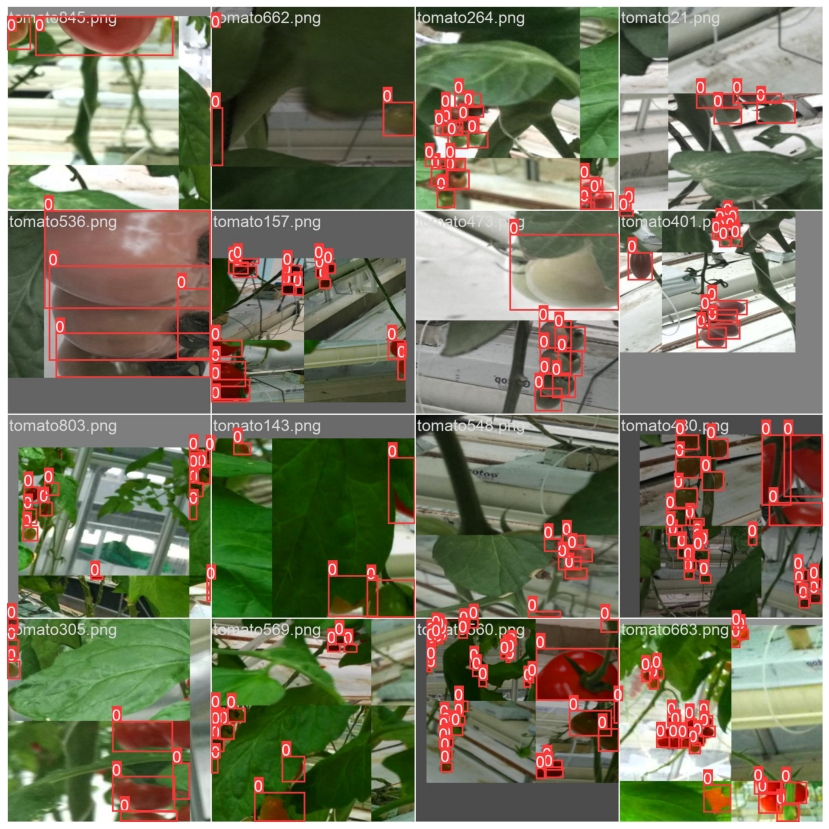

In [36]:
img = plt.imread('/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [37]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4


detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/27 /content/yolov5/data/test/images/tomato122.png: 480x640 2 with_masks, 12.7ms
image 2/27 /content/yolov5/data/test/images/tomato163.png: 480x640 5 with_masks, 11.0ms
image 3/27 /content/yolov5/data/test/images/tomato211.png: 480x640 2 with_masks, 11.0ms
image 4/27 /content/yolov5/data/test/images/tomato213.png: 480x640 1 